In [1]:
# Importing the necessary module to mount Google Drive
from google.colab import drive

# Mounting Google Drive to access files from Google Drive
# This will prompt you to authorize access to your Google Drive account
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install lime
!pip install transformers  # Installs the transformers library for NLP models
!pip install imageio       # Installs imageio to handle image files (e.g., GIFs)
!pip install gtts          # Installs Google Text-to-Speech API for text-to-speech
!pip install bert-score    # Installs the BERTScore metric library for evaluation
!pip install nltk          # Installs the NLTK library for natural language processing tasks
!pip install rouge-score   # Installs the Rouge score package for evaluation metrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=86a45403d6e68314532d8b88d3bd8c086dd5b3f4266fc2048a6bbd218d4538ff
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=693a185bfdf465a48d7e4c5c9d1616616660fb20d5ffa377216cf21759db33da
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [3]:
from lime import lime_image
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image, ImageSequence
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import torch

In [4]:

# Load the model's state dictionary
blip_model_path = '/content/drive/My Drive/Models/blip_model.pth'
data_path = '/content/drive/My Drive/Models/data.pth'

# Initialize the BLIP processor and model
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to('cuda' if torch.cuda.is_available() else 'cpu')

# Load model weights (assuming `model_path` contains only model weights)
blip_model.load_state_dict(torch.load(blip_model_path))
blip_model.eval()  # Set the model to evaluation mode

print("Trained model Blip loaded successfully.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

<ipython-input-4-209f402062cf>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  blip_model.load_state_dict(torch.load(blip_model_path))


Trained model Blip loaded successfully.


In [5]:
# Load the GIF file
gif_path = '/content/drive/My Drive/Test gifs/test.gif'
gif = Image.open(gif_path)

In [6]:
# Extract the first 5 frames from the GIF and convert them to RGB
frames = [frame.convert("RGB") for i, frame in enumerate(ImageSequence.Iterator(gif)) if i < 5]

# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

In [7]:
# Define the prediction function for LIME
def blip_predict(images):
    scores = []
    for img in images:
        # Ensure img is a NumPy array and has the correct shape
        if isinstance(img, np.ndarray):
            if img.ndim == 2:  # Convert grayscale to RGB
                img = np.stack((img,) * 3, axis=-1)
            img = Image.fromarray(img.astype('uint8'))  # Convert array back to a PIL Image if necessary

        # Process the image
        inputs = blip_processor(images=img, return_tensors="pt").to('cuda' if torch.cuda.is_available() else 'cpu')


        # Generate caption using BLIP
        with torch.no_grad():
            output = blip_model.generate(inputs["pixel_values"])
            caption = blip_processor.decode(output[0], skip_special_tokens=True)

        # Use the length of the caption as a proxy score for interpretability
        scores.append([len(caption)])
    return np.array(scores)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Caption for Frame 1: minions from des des des des des des des des des des des des des des des des des


  0%|          | 0/1000 [00:00<?, ?it/s]

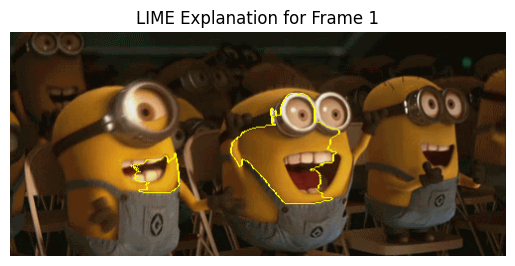

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Caption for Frame 2: minions from des des des des des des des des des des des des des des des des des


  0%|          | 0/1000 [00:00<?, ?it/s]

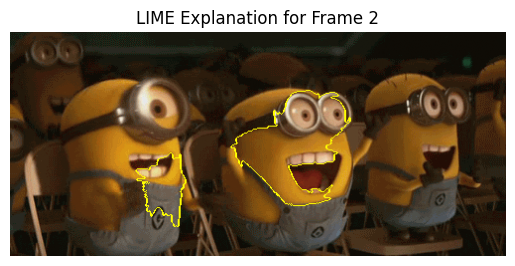

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Caption for Frame 3: minions from des des des des des des des des des des des des des des des des des


  0%|          | 0/1000 [00:00<?, ?it/s]

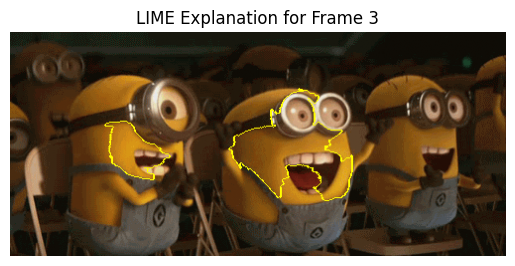

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Caption for Frame 4: a bunch of minions sitting in a row


  0%|          | 0/1000 [00:00<?, ?it/s]

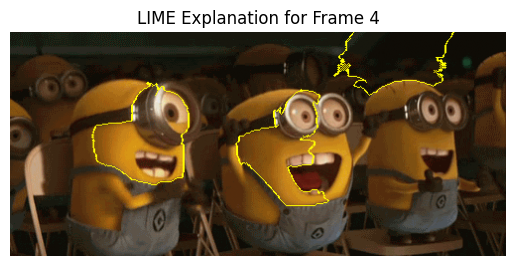

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Caption for Frame 5: a group of minions sitting in a row


  0%|          | 0/1000 [00:00<?, ?it/s]

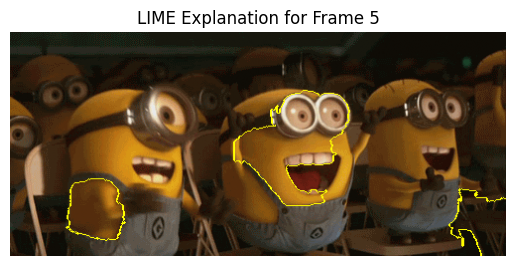

['minions from des des des des des des des des des des des des des des des des des',
 'minions from des des des des des des des des des des des des des des des des des',
 'minions from des des des des des des des des des des des des des des des des des',
 'a bunch of minions sitting in a row',
 'a group of minions sitting in a row']

In [8]:
# List to store captions for each frame
captions = []

# Loop through each selected frame
for i, frame in enumerate(frames):
    # Generate caption for each frame
    inputs = blip_processor(images=frame, return_tensors="pt").to('cuda' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():
        output = blip_model.generate(inputs["pixel_values"])
        caption = blip_processor.decode(output[0], skip_special_tokens=True)

    captions.append(caption)  # Store the caption
    print(f"Caption for Frame {i+1}: {caption}")  # Print the caption

    # Convert frame to NumPy array for LIME
    frame_array = np.array(frame)

    # Ensure the array is in RGB format if it is grayscale
    if frame_array.ndim == 2:
        frame_array = np.stack((frame_array,) * 3, axis=-1)

    # Apply LIME for interpretability on each frame
    explanation = explainer.explain_instance(
        frame_array,  # Pass the formatted frame
        blip_predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000  # Number of perturbed samples
    )

    # Visualize the explanation on the frame
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )
    # Display the LIME explanation
    plt.imshow(mark_boundaries(temp, mask))
    plt.axis("off")
    plt.title(f"LIME Explanation for Frame {i+1}")
    plt.show()

# The list of captions for the first 5 frames
captions